In [39]:
import os
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import torchvision.transforms as T
import torchvision.models as models
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from typing import Dict, List, Tuple
import timm
import random

In [40]:
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

In [41]:
npz_path = './ODIR_Data'

In [42]:
train_dir = "./ODIR_Data/train"
val_dir   = "./ODIR_Data/val"
test_dir  = "./ODIR_Data/test"

In [43]:
data = np.load("./ODIR_Data/test/0_left.npz")
print("Keys:", list(data.keys()))

Keys: ['slo_fundus', 'race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype']


In [44]:
print("dr_class example:", data["dr_class"])

dr_class example: 0


In [45]:
import numpy as np
import glob

all_labels = []

for f in glob.glob("./ODIR_Data/test/*.npz"):
    data = np.load(f)
    all_labels.append(data["dr_class"])

print("All unique dr_class values:", np.unique(all_labels))

All unique dr_class values: [0 1]


In [46]:
# visualize some data samples
npz_files = sorted(glob.glob("./ODIR_Data/train/*.npz"))

print("Number of training .npz files:", len(npz_files))

# Inspect the first 2 files
for f in npz_files[:2]:
    data = np.load(f)
    img = data["slo_fundus"]
    dr = data["dr_class"]
    sex = "Male" if data["male"] == 1 else "Female"

    print(f"\nFile: {f}")
    print("slo_fundus shape:", img.shape)
    print("DR label:", dr)
    print("Sex:", sex)

Number of training .npz files: 4476

File: ./ODIR_Data/train/1005_right.npz
slo_fundus shape: (200, 200, 3)
DR label: 0
Sex: Female

File: ./ODIR_Data/train/1006_left.npz
slo_fundus shape: (200, 200, 3)
DR label: 0
Sex: Male


In [47]:
import numpy as np
import glob

all_labels = []

for f in glob.glob("./ODIR_Data/test/*.npz"):
    data = np.load(f)
    all_labels.append(data["male"])

print("All unique dr_class values:", np.unique(all_labels))

All unique dr_class values: [0 1]


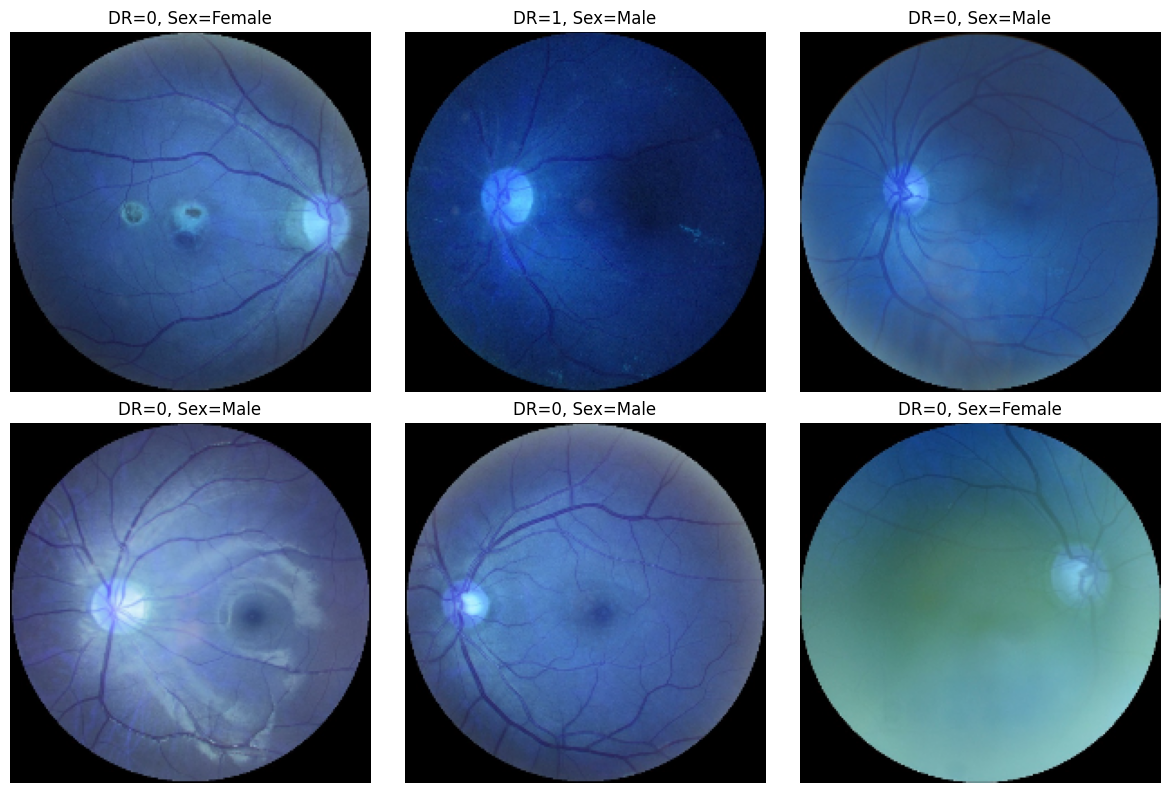

In [48]:
import random

samples = random.sample(npz_files, 6)

plt.figure(figsize=(12, 8))

for i, f in enumerate(samples):
    data = np.load(f)
    img = data["slo_fundus"]
    dr = data["dr_class"]
    sex = "Male" if data["male"] == 1 else "Female"

    # Convert to RGB for plotting
    if img.ndim == 2:
        img_plot = img
        cmap = "gray"
    else:
        img_plot = img
        cmap = None

    plt.subplot(2, 3, i+1)
    plt.imshow(img_plot, cmap=cmap)
    plt.axis("off")
    plt.title(f"DR={dr}, Sex={sex}")

plt.tight_layout()
plt.show()

In [49]:
# Dataset loader
class DRNPZFolderDataset(Dataset):
    def __init__(self, folder_path: str, transform=None):
        super().__init__()
        self.transform = transform
        self.files = sorted(glob.glob(os.path.join(folder_path, "*.npz")))
        if len(self.files) == 0:
            raise RuntimeError(f"No .npz files found in {folder_path}")

        self.images: List[np.ndarray] = []
        self.labels: List[float] = []
        self.sex: List[int] = []

        for f in self.files:
            data = np.load(f)
            img = data["slo_fundus"]
            lbl = float(data["dr_class"])
            sx = int(data["male"])

            self.images.append(img)
            self.labels.append(lbl)
            self.sex.append(sx)

        self.images = np.array(self.images, dtype=object)
        self.labels = np.array(self.labels, dtype=np.float32)
        self.sex = np.array(self.sex, dtype=np.int64)

        print(f"Loaded {len(self.images)} samples from {folder_path}")

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx: int):
        img = self.images[idx]

        # Convert numpy array to PIL Image
        # Handle different image formats and normalize to uint8
        if img.dtype != np.uint8:
            # Normalize to 0-255 range if needed
            if img.max() <= 1.0:
                img = (img * 255).astype(np.uint8)
            else:
                img = img.astype(np.uint8)
        else:
            img = img.astype(np.uint8)
        
        if img.ndim == 2:
            pil_img = Image.fromarray(img, mode="L").convert("RGB")
        elif img.ndim == 3:
            if img.shape[2] == 3:
                pil_img = Image.fromarray(img, mode="RGB")
            elif img.shape[2] == 1:
                pil_img = Image.fromarray(img.squeeze(), mode="L").convert("RGB")
            else:
                raise ValueError(f"Unsupported image shape {img.shape} at index {idx}")
        else:
            raise ValueError(f"Unsupported image shape {img.shape} at index {idx}")

        if self.transform is not None:
            pil_img = self.transform(pil_img)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        sex = torch.tensor(self.sex[idx], dtype=torch.int64)

        return pil_img, label, sex

In [50]:
# Transforms - Enhanced with better augmentation
def get_transforms(img_size, use_advanced_aug=True):
    if use_advanced_aug:
        train_tf = T.Compose([
            T.Resize((int(img_size * 1.1), int(img_size * 1.1))),  # Slightly larger for crop
            T.RandomCrop((img_size, img_size)),
            T.RandomRotation(15),  # Increased rotation
            T.RandomHorizontalFlip(p=0.5),
            T.RandomVerticalFlip(p=0.3),  # Add vertical flip
            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color augmentation
            T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225]),
            T.RandomErasing(p=0.1, scale=(0.02, 0.1)),  # Random erasing
        ])
    else:
        train_tf = T.Compose([
            T.Resize((img_size, img_size)),
            T.RandomRotation(10),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406],
                        [0.229, 0.224, 0.225])
        ])
    
    test_tf = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406],
                    [0.229, 0.224, 0.225])
    ])
    return train_tf, test_tf

In [51]:
# Model Factory
def build_model(arch, pretrained=True):
    arch = arch.lower()

    if arch == "resnet18":
        model = models.resnet18(models.ResNet18_Weights.IMAGENET1K_V1)
        n = model.fc.in_features
        model.fc = nn.Linear(n, 1)

    elif arch == "resnet50":
        model = models.resnet50(models.ResNet50_Weights.IMAGENET1K_V2)
        n = model.fc.in_features
        model.fc = nn.Linear(n, 1)

    elif arch == "densenet121":
        model = models.densenet121(models.DenseNet121_Weights.IMAGENET1K_V1)
        n = model.classifier.in_features
        model.classifier = nn.Linear(n, 1)

    elif arch == "vgg16":
        model = models.vgg16(models.VGG16_Weights.IMAGENET1K_V1)
        n = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(n, 1)

    elif arch == "efficientnet_b0":
        model = models.efficientnet_b0(models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        n = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(n, 1)
        
    elif arch == "efficientnet_b1":
        model = models.efficientnet_b1(models.EfficientNet_B1_Weights.IMAGENET1K_V2)
        n = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(n, 1)
        
    elif arch == "efficientnet_b2":
        model = models.efficientnet_b2(models.EfficientNet_B2_Weights.IMAGENET1K_V1)
        n = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(n, 1)

    elif arch == "vit_b_16":
        model = models.vit_b_16(models.ViT_B_16_Weights.IMAGENET1K_V1)
        n = model.heads.head.in_features
        model.heads.head = nn.Linear(n, 1)

    else:
        raise ValueError("Unknown arch:", arch)

    return model

In [52]:
# Focal Loss for handling hard examples
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

# Metrics
def compute_all_metrics(y_true, y_prob):
    """
    Returns dict with:
      - auc
      - precision
      - recall (sensitivity)
      - specificity
      - f1
    """
    y_true = np.array(y_true).astype(int)
    y_prob = np.array(y_prob).astype(float)

    y_pred = (y_prob >= 0.5).astype(int)

    # Handle AUC calculation - might fail if only one class
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        # All labels are the same class
        auc = 0.0

    # Handle confusion matrix - might fail if only one class
    try:
        cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
        if cm.size == 1:
            # Only one class present
            if y_true[0] == 0:
                tn, fp, fn, tp = len(y_true), 0, 0, 0
            else:
                tn, fp, fn, tp = 0, 0, 0, len(y_true)
        else:
            tn, fp, fn, tp = cm.ravel()
    except Exception as e:
        # Fallback calculation
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))

    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    specificity = tn / (tn + fp + 1e-8)

    return {
        "auc": auc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1": f1,
    }


def print_results(results: Dict[str, Dict[str, float]]):
    """
    Pretty-print overall / female / male metrics.
    """
    for group, m in results.items():
        print(f"\n====== {group.upper()} ======")
        if m is None:
            print("No samples in this group.")
            continue
        print(f"AUC:         {m['auc']:.4f}")
        print(f"Precision:   {m['precision']:.4f}")
        print(f"Recall:      {m['recall']:.4f}")
        print(f"Specificity: {m['specificity']:.4f}")
        print(f"F1 Score:    {m['f1']:.4f}")

# Confusion Matrix Plot
def plot_confmat(true, prob, save_path):
    pred = (prob >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(true, pred, labels=[0, 1]).ravel()

    mat = np.array([[tn, fp],
                    [fn, tp]])

    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(mat, cmap="Blues")

    for i in range(2):
        for j in range(2):
            ax.text(j, i, mat[i, j], ha="center", va="center", fontsize=14)

    ax.set_title("Confusion Matrix")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["0", "1"])
    ax.set_yticklabels(["0", "1"])
    plt.colorbar(im)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

In [53]:
# Test-Time Augmentation (TTA) for better inference - OPTIMIZED VERSION
def evaluate_with_tta(model: nn.Module,
                      loader: DataLoader,
                      device: torch.device,
                      tta_transforms: List = None,
                      num_augments: int = 5) -> Dict[str, Dict[str, float]]:
    """
    Evaluate with Test-Time Augmentation (OPTIMIZED).
    Uses multiple augmented versions of each image and averages predictions.
    This version processes batches efficiently on GPU.
    """
    if tta_transforms is None:
        # Default TTA transforms - using functional transforms for batch processing
        num_augments = 5
    else:
        num_augments = min(num_augments, len(tta_transforms)) if tta_transforms else 5
    
    model.eval()
    all_probs = []
    all_labels = []
    all_sex = []
    
    # Normalization constants
    mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)

    with torch.no_grad():
        for images, labels, sex in loader:
            images = images.to(device)
            
            # Average predictions over TTA - process entire batch at once
            probs_list = []
            
            # 1. Original (no augmentation) - always included
            logits = model(images).squeeze(1)
            probs = torch.sigmoid(logits)
            probs_list.append(probs)
            
            if num_augments >= 2:
                # 2. Horizontal flip
                images_hflip = torch.flip(images, dims=[3])
                logits = model(images_hflip).squeeze(1)
                probs = torch.sigmoid(logits)
                probs_list.append(probs)
            
            if num_augments >= 3:
                # 3. Vertical flip
                images_vflip = torch.flip(images, dims=[2])
                logits = model(images_vflip).squeeze(1)
                probs = torch.sigmoid(logits)
                probs_list.append(probs)
            
            if num_augments >= 4:
                # 4. Both flips
                images_both_flip = torch.flip(images, dims=[2, 3])
                logits = model(images_both_flip).squeeze(1)
                probs = torch.sigmoid(logits)
                probs_list.append(probs)
            
            if num_augments >= 5:
                # 5. Rotation (90 degrees)
                images_rot = torch.rot90(images, k=1, dims=[2, 3])
                logits = model(images_rot).squeeze(1)
                probs = torch.sigmoid(logits)
                probs_list.append(probs)
            
            # Average probabilities
            avg_probs = torch.stack(probs_list).mean(dim=0).cpu().numpy()
            
            all_probs.append(avg_probs)
            all_labels.append(labels.numpy())
            all_sex.append(sex.numpy())

    probs = np.concatenate(all_probs)
    labels = np.concatenate(all_labels).astype(int)
    sex = np.concatenate(all_sex).astype(int)

    results: Dict[str, Dict[str, float]] = {}

    # Overall
    results["overall"] = compute_all_metrics(labels, probs)

    # Female (male == 0)
    f_idx = (sex == 0)
    if f_idx.any():
        results["female"] = compute_all_metrics(labels[f_idx], probs[f_idx])
    else:
        results["female"] = None

    # Male (male == 1)
    m_idx = (sex == 1)
    if m_idx.any():
        results["male"] = compute_all_metrics(labels[m_idx], probs[m_idx])
    else:
        results["male"] = None

    return results

# Evaluation
# ============================

def evaluate(model: nn.Module,
             loader: DataLoader,
             device: torch.device) -> Dict[str, Dict[str, float]]:
    """
    Evaluate on a loader and compute metrics for:
      - overall
      - female (male == 0)
      - male   (male == 1)
    """
    model.eval()
    all_probs = []
    all_labels = []
    all_sex = []

    with torch.no_grad():
        for images, labels, sex in loader:
            images = images.to(device)
            logits = model(images).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()

            all_probs.append(probs)
            all_labels.append(labels.numpy())
            all_sex.append(sex.numpy())

    probs = np.concatenate(all_probs)
    labels = np.concatenate(all_labels).astype(int)
    sex = np.concatenate(all_sex).astype(int)

    results: Dict[str, Dict[str, float]] = {}

    # Overall
    results["overall"] = compute_all_metrics(labels, probs)

    # Female (male == 0)
    f_idx = (sex == 0)
    if f_idx.any():
        results["female"] = compute_all_metrics(labels[f_idx], probs[f_idx])
    else:
        results["female"] = None

    # Male (male == 1)
    m_idx = (sex == 1)
    if m_idx.any():
        results["male"] = compute_all_metrics(labels[m_idx], probs[m_idx])
    else:
        results["male"] = None

    return results

In [54]:
# Training
# ============================

def train_one_epoch(model: nn.Module,
                    loader: DataLoader,
                    optimizer: torch.optim.Optimizer,
                    loss_fn: nn.Module,
                    device: torch.device,
                    scaler=None) -> float:
    model.train()
    total_loss = 0.0

    for images, labels, _ in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        # Mixed precision training
        if scaler is not None:
            with torch.amp.autocast("cuda:3"):
                logits = model(images).squeeze(1)
                loss = loss_fn(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(images).squeeze(1)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * images.size(0)

    return total_loss / len(loader.dataset)


def train_backbone(
    arch: str,
    root_dir: str = "./ODIR_Data",
    img_size: int = 224,
    batch_size: int = 32,
    epochs: int = 10,
    lr: float = 1e-4,
    weight_decay: float = 1e-5,
    num_workers: int = 4,
    out_dir: str = "./dr_notebook_results",
    device: torch.device = None,
    use_focal_loss: bool = False,
    use_class_weights: bool = True,
    early_stopping_patience: int = 7,
    use_mixed_precision: bool = True,
    use_advanced_aug: bool = True,
) -> Tuple[nn.Module, Dict[str, Dict[str, float]]]:
    """
    Trains a single backbone directly from Jupyter (no argparse).
    Enhanced with:
    - Learning rate scheduling
    - Early stopping
    - Class weight balancing
    - Focal loss option
    - Mixed precision training
    - Advanced augmentation
    
    Returns: trained model, test_results dict.
    """
    if device is None:
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
    print(f"\n=== Training {arch} on device: {device} ===")
    print(f"Settings: Focal Loss={use_focal_loss}, Class Weights={use_class_weights}, "
          f"Early Stop={early_stopping_patience}, Mixed Precision={use_mixed_precision}, "
          f"Advanced Aug={use_advanced_aug}")

    train_tf, eval_tf = get_transforms(img_size, use_advanced_aug=use_advanced_aug)

    train_ds = DRNPZFolderDataset(os.path.join(root_dir, "train"), transform=train_tf)
    val_ds   = DRNPZFolderDataset(os.path.join(root_dir, "val"),   transform=eval_tf)
    test_ds  = DRNPZFolderDataset(os.path.join(root_dir, "test"),  transform=eval_tf)

    # Calculate class weights if needed
    if use_class_weights:
        train_labels = train_ds.labels
        class_counts = np.bincount(train_labels.astype(int))
        total = len(train_labels)
        class_weights = torch.tensor([total / (2.0 * count) for count in class_counts], dtype=torch.float32).to(device)
        print(f"Class weights: {class_weights.cpu().numpy()}")
        pos_weight = class_weights[1] / class_weights[0] if len(class_weights) > 1 else torch.tensor(1.0).to(device)
    else:
        pos_weight = torch.tensor(1.0).to(device)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=(device.type == "cuda"))
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=(device.type == "cuda"))
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=(device.type == "cuda"))

    model = build_model(arch, pretrained=True).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True, min_lr=1e-7
    )
    
    # Loss function
    if use_focal_loss:
        loss_fn = FocalLoss(alpha=1.0, gamma=2.0)
    else:
        loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    os.makedirs(out_dir, exist_ok=True)
    best_val_auc = -1.0
    best_state = None
    patience_counter = 0
    
    # Mixed precision scaler
    scaler = torch.amp.GradScaler("cuda:3") if use_mixed_precision and device.type == "cuda" else None

    for epoch in range(1, epochs + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device, scaler)

        # Validation
        model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for images, labels, _ in val_loader:
                images = images.to(device)
                if scaler is not None:
                    with torch.amp.autocast("cuda:3"):
                        logits = model(images).squeeze(1)
                        probs = torch.sigmoid(logits).cpu().numpy()
                else:
                    logits = model(images).squeeze(1)
                    probs = torch.sigmoid(logits).cpu().numpy()
                all_probs.append(probs)
                all_labels.append(labels.numpy())

        val_probs = np.concatenate(all_probs)
        val_labels = np.concatenate(all_labels)
        val_metrics = compute_all_metrics(val_labels, val_probs)
        
        # Update learning rate
        scheduler.step(val_metrics['auc'])
        current_lr = optimizer.param_groups[0]['lr']

        print(
            f"[{arch}] Epoch {epoch}/{epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val AUC: {val_metrics['auc']:.4f} | "
            f"Val F1: {val_metrics['f1']:.4f} | "
            f"LR: {current_lr:.2e}"
        )

        if val_metrics["auc"] > best_val_auc:
            best_val_auc = val_metrics["auc"]
            best_state = model.state_dict()
            patience_counter = 0
            print(f"  ✓ New best AUC: {best_val_auc:.4f}")
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print(f"  ⚠ Early stopping triggered after {early_stopping_patience} epochs without improvement")
                break

    # Load best and save
    if best_state is not None:
        model.load_state_dict(best_state)
        ckpt_path = os.path.join(out_dir, f"best_{arch}.pt")
        torch.save({
            'model_state_dict': best_state,
            'best_val_auc': best_val_auc,
            'arch': arch,
            'img_size': img_size,
        }, ckpt_path)
        print(f"Best {arch} checkpoint saved to: {ckpt_path} (AUC: {best_val_auc:.4f})")

    # Final test evaluation
    test_results = evaluate(model, test_loader, device)
    print("\n=== Final Test Metrics ===")
    print_results(test_results)

    return model, test_results

In [55]:
import csv

def train_multiple_backbones(
    arch_list,
    root_dir="./ODIR_Data",
    img_size=224,
    batch_size=32,
    epochs=10,
    lr=1e-4,
    weight_decay=1e-5,
    num_workers=4,
    out_dir="./dr_notebook_results",
    csv_path="./dr_results.csv",
    device=None,
    use_focal_loss=True,
    use_class_weights=True,
    early_stopping_patience=15,
    use_mixed_precision=True,
    use_advanced_aug=True,
):
    """
    Trains multiple backbones sequentially and logs metrics to CSV.
    arch_list: ["resnet50", "densenet121", ...]
    """
    if device is None:
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

    # Prepare output folder
    os.makedirs(out_dir, exist_ok=True)

    # Initialize CSV file
    write_header = not os.path.exists(csv_path)
    with open(csv_path, "a", newline="") as f:
        writer = csv.writer(f)
        if write_header:
            writer.writerow([
                "backbone",
                "group",
                "auc",
                "precision",
                "recall",
                "specificity",
                "f1"
            ])

    all_results = {}

    # Train each backbone sequentially
    for arch in arch_list:
        print("\n=============================================")
        print(f"        TRAINING BACKBONE: {arch}")
        print("=============================================\n")

        try:
            model, metrics = train_backbone(
                arch=arch,
                root_dir=root_dir,
                img_size=img_size,
                batch_size=batch_size,
                epochs=epochs,
                lr=lr,
                weight_decay=weight_decay,
                num_workers=num_workers,
                out_dir=out_dir,
                device=device,
                use_focal_loss=use_focal_loss,
                use_class_weights=use_class_weights,
                early_stopping_patience=early_stopping_patience,
                use_mixed_precision=use_mixed_precision,
                use_advanced_aug=use_advanced_aug,
            )

            all_results[arch] = metrics

            # Append results to CSV
            with open(csv_path, "a", newline="") as f:
                writer = csv.writer(f)
                for group, m in metrics.items():
                    if m is None:
                        writer.writerow([arch, group, "NA", "NA", "NA", "NA", "NA"])
                    else:
                        writer.writerow([
                            arch,
                            group,
                            m["auc"],
                            m["precision"],
                            m["recall"],
                            m["specificity"],
                            m["f1"]
                        ])
        except Exception as e:
            print(f"\n✗ Error training {arch}: {e}")
            import traceback
            traceback.print_exc()
            continue

    print("\nAll backbones complete. Results saved in:", csv_path)
    
    # Plot results if requested
    if plot_results and all_results:
        print("\n" + "="*50)
        print("Generating comparison plots...")
        print("="*50)
        plot_path = os.path.join(out_dir, 'backbone_auc_comparison.png')
        plot_backbone_comparison(all_results, metric='auc', save_path=plot_path)
    
    return all_results

In [20]:
results = train_multiple_backbones(
    arch_list=["resnet50", "densenet121", "vgg16", "efficientnet_b0", "vit_b_16", "efficientnet_b1", "efficientnet_b2", "resnet18"],
    root_dir="./ODIR_Data",
    img_size=224,
    batch_size=32,
    epochs=50,
    lr=1e-4,
    weight_decay=1e-5,
    out_dir="./dr_notebook_results",
    csv_path="./dr_results.csv"
)


        TRAINING BACKBONE: resnet50


=== Training resnet50 on device: cuda:3 ===
Settings: Focal Loss=True, Class Weights=True, Early Stop=15, Mixed Precision=True, Advanced Aug=True
Loaded 4476 samples from ./ODIR_Data/train
Loaded 641 samples from ./ODIR_Data/val
Loaded 1914 samples from ./ODIR_Data/test
Class weights: [0.66646814 2.0017889 ]


/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[resnet50] Epoch 1/50 | Train Loss: 0.1377 | Val AUC: 0.6915 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.6915
[resnet50] Epoch 2/50 | Train Loss: 0.1271 | Val AUC: 0.7527 | Val F1: 0.2655 | LR: 1.00e-04
  ✓ New best AUC: 0.7527
[resnet50] Epoch 3/50 | Train Loss: 0.1206 | Val AUC: 0.7764 | Val F1: 0.3898 | LR: 1.00e-04
  ✓ New best AUC: 0.7764
[resnet50] Epoch 4/50 | Train Loss: 0.1145 | Val AUC: 0.7792 | Val F1: 0.4840 | LR: 1.00e-04
  ✓ New best AUC: 0.7792
[resnet50] Epoch 5/50 | Train Loss: 0.1142 | Val AUC: 0.7954 | Val F1: 0.4068 | LR: 1.00e-04
  ✓ New best AUC: 0.7954
[resnet50] Epoch 6/50 | Train Loss: 0.1087 | Val AUC: 0.7929 | Val F1: 0.5199 | LR: 1.00e-04
[resnet50] Epoch 7/50 | Train Loss: 0.1054 | Val AUC: 0.7737 | Val F1: 0.3119 | LR: 1.00e-04
[resnet50] Epoch 8/50 | Train Loss: 0.1009 | Val AUC: 0.8068 | Val F1: 0.5629 | LR: 1.00e-04
  ✓ New best AUC: 0.8068
[resnet50] Epoch 9/50 | Train Loss: 0.0988 | Val AUC: 0.7956 | Val F1: 0.5132 | LR: 1.00e-04
[resnet50] Ep

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[densenet121] Epoch 1/50 | Train Loss: 0.1457 | Val AUC: 0.7433 | Val F1: 0.0323 | LR: 1.00e-04
  ✓ New best AUC: 0.7433
[densenet121] Epoch 2/50 | Train Loss: 0.1304 | Val AUC: 0.7518 | Val F1: 0.2190 | LR: 1.00e-04
  ✓ New best AUC: 0.7518
[densenet121] Epoch 3/50 | Train Loss: 0.1241 | Val AUC: 0.7668 | Val F1: 0.4017 | LR: 1.00e-04
  ✓ New best AUC: 0.7668
[densenet121] Epoch 4/50 | Train Loss: 0.1179 | Val AUC: 0.7738 | Val F1: 0.4050 | LR: 1.00e-04
  ✓ New best AUC: 0.7738
[densenet121] Epoch 5/50 | Train Loss: 0.1161 | Val AUC: 0.7964 | Val F1: 0.3745 | LR: 1.00e-04
  ✓ New best AUC: 0.7964
[densenet121] Epoch 6/50 | Train Loss: 0.1118 | Val AUC: 0.8119 | Val F1: 0.5486 | LR: 1.00e-04
  ✓ New best AUC: 0.8119
[densenet121] Epoch 7/50 | Train Loss: 0.1094 | Val AUC: 0.7750 | Val F1: 0.3451 | LR: 1.00e-04
[densenet121] Epoch 8/50 | Train Loss: 0.1071 | Val AUC: 0.8129 | Val F1: 0.5056 | LR: 1.00e-04
  ✓ New best AUC: 0.8129
[densenet121] Epoch 9/50 | Train Loss: 0.1034 | Val AUC: 

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[vgg16] Epoch 1/50 | Train Loss: 0.1485 | Val AUC: 0.6268 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.6268
[vgg16] Epoch 2/50 | Train Loss: 0.1421 | Val AUC: 0.6351 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.6351
[vgg16] Epoch 3/50 | Train Loss: 0.1441 | Val AUC: 0.6186 | Val F1: 0.0000 | LR: 1.00e-04
[vgg16] Epoch 4/50 | Train Loss: 0.1424 | Val AUC: 0.6344 | Val F1: 0.0000 | LR: 1.00e-04
[vgg16] Epoch 5/50 | Train Loss: 0.1388 | Val AUC: 0.6264 | Val F1: 0.0000 | LR: 1.00e-04
[vgg16] Epoch 6/50 | Train Loss: 0.1407 | Val AUC: 0.6704 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.6704
[vgg16] Epoch 7/50 | Train Loss: 0.1393 | Val AUC: 0.6350 | Val F1: 0.0000 | LR: 1.00e-04
[vgg16] Epoch 8/50 | Train Loss: 0.1389 | Val AUC: 0.6490 | Val F1: 0.0000 | LR: 1.00e-04
[vgg16] Epoch 9/50 | Train Loss: 0.1375 | Val AUC: 0.6419 | Val F1: 0.0000 | LR: 1.00e-04
[vgg16] Epoch 10/50 | Train Loss: 0.1347 | Val AUC: 0.6540 | Val F1: 0.0000 | LR: 5.00e-05
[vgg16] Epoch 11/50 | Tr

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[efficientnet_b0] Epoch 1/50 | Train Loss: 0.1427 | Val AUC: 0.7131 | Val F1: 0.3052 | LR: 1.00e-04
  ✓ New best AUC: 0.7131
[efficientnet_b0] Epoch 2/50 | Train Loss: 0.1324 | Val AUC: 0.7011 | Val F1: 0.2743 | LR: 1.00e-04
[efficientnet_b0] Epoch 3/50 | Train Loss: 0.1249 | Val AUC: 0.7054 | Val F1: 0.3534 | LR: 1.00e-04
[efficientnet_b0] Epoch 4/50 | Train Loss: 0.1207 | Val AUC: 0.7556 | Val F1: 0.4000 | LR: 1.00e-04
  ✓ New best AUC: 0.7556
[efficientnet_b0] Epoch 5/50 | Train Loss: 0.1179 | Val AUC: 0.7634 | Val F1: 0.3629 | LR: 1.00e-04
  ✓ New best AUC: 0.7634
[efficientnet_b0] Epoch 6/50 | Train Loss: 0.1126 | Val AUC: 0.7828 | Val F1: 0.4855 | LR: 1.00e-04
  ✓ New best AUC: 0.7828
[efficientnet_b0] Epoch 7/50 | Train Loss: 0.1123 | Val AUC: 0.8053 | Val F1: 0.4511 | LR: 1.00e-04
  ✓ New best AUC: 0.8053
[efficientnet_b0] Epoch 8/50 | Train Loss: 0.1102 | Val AUC: 0.7838 | Val F1: 0.4093 | LR: 1.00e-04
[efficientnet_b0] Epoch 9/50 | Train Loss: 0.1048 | Val AUC: 0.7982 | Val F

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[vit_b_16] Epoch 1/50 | Train Loss: 0.1560 | Val AUC: 0.6883 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.6883
[vit_b_16] Epoch 2/50 | Train Loss: 0.1408 | Val AUC: 0.6627 | Val F1: 0.0000 | LR: 1.00e-04
[vit_b_16] Epoch 3/50 | Train Loss: 0.1390 | Val AUC: 0.7081 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.7081
[vit_b_16] Epoch 4/50 | Train Loss: 0.1396 | Val AUC: 0.7269 | Val F1: 0.0000 | LR: 1.00e-04
  ✓ New best AUC: 0.7269
[vit_b_16] Epoch 5/50 | Train Loss: 0.1382 | Val AUC: 0.7128 | Val F1: 0.0000 | LR: 1.00e-04
[vit_b_16] Epoch 6/50 | Train Loss: 0.1360 | Val AUC: 0.6808 | Val F1: 0.0000 | LR: 1.00e-04
[vit_b_16] Epoch 7/50 | Train Loss: 0.1374 | Val AUC: 0.7246 | Val F1: 0.0825 | LR: 1.00e-04
[vit_b_16] Epoch 8/50 | Train Loss: 0.1362 | Val AUC: 0.7067 | Val F1: 0.0632 | LR: 5.00e-05
[vit_b_16] Epoch 9/50 | Train Loss: 0.1293 | Val AUC: 0.7502 | Val F1: 0.2807 | LR: 5.00e-05
  ✓ New best AUC: 0.7502
[vit_b_16] Epoch 10/50 | Train Loss: 0.1286 | Val AUC: 0.7448 |

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[efficientnet_b1] Epoch 1/50 | Train Loss: 0.1398 | Val AUC: 0.7299 | Val F1: 0.0216 | LR: 1.00e-04
  ✓ New best AUC: 0.7299
[efficientnet_b1] Epoch 2/50 | Train Loss: 0.1295 | Val AUC: 0.7448 | Val F1: 0.1863 | LR: 1.00e-04
  ✓ New best AUC: 0.7448
[efficientnet_b1] Epoch 3/50 | Train Loss: 0.1221 | Val AUC: 0.7721 | Val F1: 0.2453 | LR: 1.00e-04
  ✓ New best AUC: 0.7721
[efficientnet_b1] Epoch 4/50 | Train Loss: 0.1181 | Val AUC: 0.7829 | Val F1: 0.3097 | LR: 1.00e-04
  ✓ New best AUC: 0.7829
[efficientnet_b1] Epoch 5/50 | Train Loss: 0.1153 | Val AUC: 0.7923 | Val F1: 0.3478 | LR: 1.00e-04
  ✓ New best AUC: 0.7923
[efficientnet_b1] Epoch 6/50 | Train Loss: 0.1119 | Val AUC: 0.7992 | Val F1: 0.2727 | LR: 1.00e-04
  ✓ New best AUC: 0.7992
[efficientnet_b1] Epoch 7/50 | Train Loss: 0.1088 | Val AUC: 0.7990 | Val F1: 0.3478 | LR: 1.00e-04
[efficientnet_b1] Epoch 8/50 | Train Loss: 0.1089 | Val AUC: 0.8154 | Val F1: 0.3049 | LR: 1.00e-04
  ✓ New best AUC: 0.8154
[efficientnet_b1] Epoch 9

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[efficientnet_b2] Epoch 1/50 | Train Loss: 0.1419 | Val AUC: 0.6919 | Val F1: 0.3004 | LR: 1.00e-04
  ✓ New best AUC: 0.6919
[efficientnet_b2] Epoch 2/50 | Train Loss: 0.1297 | Val AUC: 0.7212 | Val F1: 0.2488 | LR: 1.00e-04
  ✓ New best AUC: 0.7212
[efficientnet_b2] Epoch 3/50 | Train Loss: 0.1231 | Val AUC: 0.7567 | Val F1: 0.4064 | LR: 1.00e-04
  ✓ New best AUC: 0.7567
[efficientnet_b2] Epoch 4/50 | Train Loss: 0.1164 | Val AUC: 0.7586 | Val F1: 0.3951 | LR: 1.00e-04
  ✓ New best AUC: 0.7586
[efficientnet_b2] Epoch 5/50 | Train Loss: 0.1115 | Val AUC: 0.7785 | Val F1: 0.3967 | LR: 1.00e-04
  ✓ New best AUC: 0.7785
[efficientnet_b2] Epoch 6/50 | Train Loss: 0.1063 | Val AUC: 0.7832 | Val F1: 0.3882 | LR: 1.00e-04
  ✓ New best AUC: 0.7832
[efficientnet_b2] Epoch 7/50 | Train Loss: 0.1064 | Val AUC: 0.7817 | Val F1: 0.3866 | LR: 1.00e-04
[efficientnet_b2] Epoch 8/50 | Train Loss: 0.1017 | Val AUC: 0.7818 | Val F1: 0.3509 | LR: 1.00e-04
[efficientnet_b2] Epoch 9/50 | Train Loss: 0.0976 

/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/bin/miniconda3/envs/torch_medai/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[resnet18] Epoch 1/50 | Train Loss: 0.1520 | Val AUC: 0.7113 | Val F1: 0.4239 | LR: 1.00e-04
  ✓ New best AUC: 0.7113
[resnet18] Epoch 2/50 | Train Loss: 0.1370 | Val AUC: 0.7505 | Val F1: 0.2907 | LR: 1.00e-04
  ✓ New best AUC: 0.7505
[resnet18] Epoch 3/50 | Train Loss: 0.1305 | Val AUC: 0.7593 | Val F1: 0.2262 | LR: 1.00e-04
  ✓ New best AUC: 0.7593
[resnet18] Epoch 4/50 | Train Loss: 0.1254 | Val AUC: 0.7604 | Val F1: 0.4702 | LR: 1.00e-04
  ✓ New best AUC: 0.7604
[resnet18] Epoch 5/50 | Train Loss: 0.1196 | Val AUC: 0.7661 | Val F1: 0.3207 | LR: 1.00e-04
  ✓ New best AUC: 0.7661
[resnet18] Epoch 6/50 | Train Loss: 0.1178 | Val AUC: 0.7827 | Val F1: 0.2254 | LR: 1.00e-04
  ✓ New best AUC: 0.7827
[resnet18] Epoch 7/50 | Train Loss: 0.1148 | Val AUC: 0.7588 | Val F1: 0.3167 | LR: 1.00e-04
[resnet18] Epoch 8/50 | Train Loss: 0.1130 | Val AUC: 0.7866 | Val F1: 0.4706 | LR: 1.00e-04
  ✓ New best AUC: 0.7866
[resnet18] Epoch 9/50 | Train Loss: 0.1104 | Val AUC: 0.7769 | Val F1: 0.4202 | L

In [68]:
# Visualization functions for comparing backbone performance
# Note: matplotlib.pyplot, pandas are already imported above

def plot_backbone_comparison(all_results: Dict[str, Dict[str, Dict[str, float]]], 
                            metric: str = 'auc',
                            save_path: str = None,
                            figsize: Tuple[int, int] = (6, 12),
                            orientation: str = 'horizontal'):
    """
    Plot comparison bar charts for backbone performance.
    
    Args:
        all_results: Dictionary with structure {backbone_name: {group: {metric: value}}}
        metric: Metric to plot (default: 'auc')
        save_path: Optional path to save the figure
        figsize: Figure size (width, height)
        orientation: 'horizontal' (bars go left-right) or 'vertical' (bars go up-down)
    """
    if orientation not in ['horizontal', 'vertical']:
        print("Warning: orientation must be 'horizontal' or 'vertical'. Using 'horizontal'.")
        orientation = 'horizontal'
    
    # Adjust figsize based on orientation
    if orientation == 'vertical':
        figsize = (figsize[1], figsize[0])  # Swap width and height for vertical
    if not all_results:
        print("No results to plot!")
        return
    
    # Extract overall metrics
    backbone_data = []
    
    for backbone, metrics in all_results.items():
        if metrics is not None and 'overall' in metrics and metrics['overall'] is not None:
            metric_value = metrics['overall'].get(metric, 0.0)
            backbone_data.append((backbone, metric_value))
    
    if not backbone_data:
        print("No overall metrics found!")
        return
    
    # Sort by metric value (descending) for better visualization
    backbone_data.sort(key=lambda x: x[1], reverse=True)
    backbones, overall_aucs = zip(*backbone_data)
    backbones = list(backbones)
    overall_aucs = list(overall_aucs)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Overall AUC comparison
    # Use a better colormap for distinct, visually appealing colors
    # Options: 'Set2', 'Set3', 'tab10', 'plasma', 'coolwarm', or performance-based
    if len(backbones) <= 10:
        # Use distinct qualitative colors for better differentiation
        colors= plt.cm.Set2(np.linspace(0, 1, len(backbones)))
    else:
        # Use a gradient for many backbones
        colors= plt.cm.plasma(np.linspace(0, 1, len(backbones)))
    
#     # Alternative: Performance-based colors (green=high, red=low)
#     colors_3 = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(backbones)))[::-1]  # Reversed
    
    if orientation == 'horizontal':
        bars1 = ax1.barh(backbones, overall_aucs, color=colors_1)
        ax1.set_xlabel(f'Overall {metric.upper()}', fontsize=12, fontweight='bold')
        ax1.set_ylabel('Backbone', fontsize=12, fontweight='bold')
        ax1.set_xlim([min(overall_aucs) * 0.95, max(overall_aucs) * 1.05])
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        # Add value labels on bars
        for i, (bar, auc) in enumerate(zip(bars1, overall_aucs)):
            ax1.text(auc, i, f' {auc:.2f}', va='center', fontsize=10, fontweight='bold')
    else:  # vertical
        bars1 = ax1.bar(backbones, overall_aucs, color=colors)
        ax1.set_ylabel(f'Overall {metric.upper()}', fontsize=12, fontweight='bold')
        ax1.set_xlabel('Backbone', fontsize=12, fontweight='bold')
        ax1.set_ylim([min(overall_aucs) * 0.95, max(overall_aucs) * 1.05])
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        ax1.tick_params(axis='x', rotation=45)
        # Add value labels on bars
        for bar, auc in zip(bars1, overall_aucs):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f' {auc:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold', rotation=0)
    
    ax1.set_title(f'Overall {metric.upper()} Comparison Across Backbones', fontsize=14, fontweight='bold')
    
    # Plot 2: Female vs Male AUC comparison
    # Maintain the same order as the sorted backbones
    female_aucs = []
    male_aucs = []
    valid_backbones = []
    
    for backbone in backbones:
        metrics = all_results[backbone]
        female_auc = metrics.get('female', {}).get(metric, None) if metrics and metrics.get('female') else None
        male_auc = metrics.get('male', {}).get(metric, None) if metrics and metrics.get('male') else None
        
        if female_auc is not None and male_auc is not None:
            valid_backbones.append(backbone)
            female_aucs.append(female_auc)
            male_aucs.append(male_auc)
    
    if valid_backbones:
        x = np.arange(len(valid_backbones))
        width = 0.30
        
        if orientation == 'horizontal':
            bars2_f = ax2.barh(x - width/2, female_aucs, width, label='Female', color='#FF6B9D', alpha=0.8)
            bars2_m = ax2.barh(x + width/2, male_aucs, width, label='Male', color='#4ECDC4', alpha=0.8)
            
            ax2.set_xlabel(f'{metric.upper()}', fontsize=12, fontweight='bold')
            ax2.set_ylabel('Backbone', fontsize=12, fontweight='bold')
            ax2.set_yticks(x)
            ax2.set_yticklabels(valid_backbones)
            ax2.legend(loc='lower right', fontsize=11)
            ax2.grid(axis='x', alpha=0.3, linestyle='--')
            
            # Add value labels
            for bars in [bars2_f, bars2_m]:
                for bar in bars:
                    width_bar = bar.get_width()
                    y_pos = bar.get_y() + bar.get_height() / 2
                    ax2.text(width_bar, y_pos, f' {width_bar:.2f}', va='center', fontsize=9)
            
            # Set xlim to accommodate labels
            all_vals = female_aucs + male_aucs
            ax2.set_xlim([min(all_vals) * 0.95, max(all_vals) * 1.05])
        else:  # vertical
            bars2_f = ax2.bar(x - width/2, female_aucs, width, label='Female', color='#FF6B9D', alpha=0.8)
            bars2_m = ax2.bar(x + width/2, male_aucs, width, label='Male', color='#4ECDC4', alpha=0.8)
            
            ax2.set_ylabel(f'{metric.upper()}', fontsize=12, fontweight='bold')
            ax2.set_xlabel('Backbone', fontsize=12, fontweight='bold')
            ax2.set_xticks(x)
            ax2.set_xticklabels(valid_backbones, rotation=45, ha='right')
            ax2.legend(loc='upper left', fontsize=11)
            ax2.grid(axis='y', alpha=0.3, linestyle='--')
            
            # Add value labels
            for bars in [bars2_f, bars2_m]:
                for bar in bars:
                    height = bar.get_height()
                    ax2.text(bar.get_x() + bar.get_width()/2., height,
                            f' {height:.2f}', ha='center', va='bottom', fontsize=7, rotation=45)
            
            # Set ylim to accommodate labels
            all_vals = female_aucs + male_aucs
            ax2.set_ylim([min(all_vals) * 0.95, max(all_vals) * 1.05])
        
        ax2.set_title(f'Female vs Male {metric.upper()} Comparison', fontsize=14, fontweight='bold')
    else:
        ax2.text(0.5, 0.5, 'No Female/Male data available', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=12)
        ax2.set_title(f'Female vs Male {metric.upper()} Comparison', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to: {save_path}")
    
    plt.show()


def plot_comparison_from_csv(csv_path: str,
                            metric: str = 'auc',
                            save_path: str = None,
                            figsize: Tuple[int, int] = (6, 12),
                            orientation: str = 'horizontal'):
    """
    Plot comparison charts from CSV results file.
    
    Args:
        csv_path: Path to CSV file with results
        metric: Metric to plot (default: 'auc')
        save_path: Optional path to save the figure
        figsize: Figure size (width, height)
        orientation: 'horizontal' (bars go left-right) or 'vertical' (bars go up-down)
    """
    try:
        df = pd.read_csv(csv_path)
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return
    
    if metric not in df.columns:
        print(f"Metric '{metric}' not found in CSV columns: {df.columns.tolist()}")
        return
    
    # Reconstruct all_results structure from CSV
    all_results = {}
    for _, row in df.iterrows():
        backbone = row['backbone']
        group = row['group']
        metric_value = row[metric]
        
        if backbone not in all_results:
            all_results[backbone] = {}
        
        all_results[backbone][group] = {metric: metric_value}
    
    plot_backbone_comparison(all_results, metric=metric, save_path=save_path, 
                            figsize=figsize, orientation=orientation)


## Dataset Characteristics Exploration

Explore the distribution of various dataset features across train, val, and test sets.


Loading dataset...
Total files processed: 7031
Keys analyzed: ['race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype']


Figure saved to: ./dr_notebook_results/dataset_characteristics.png


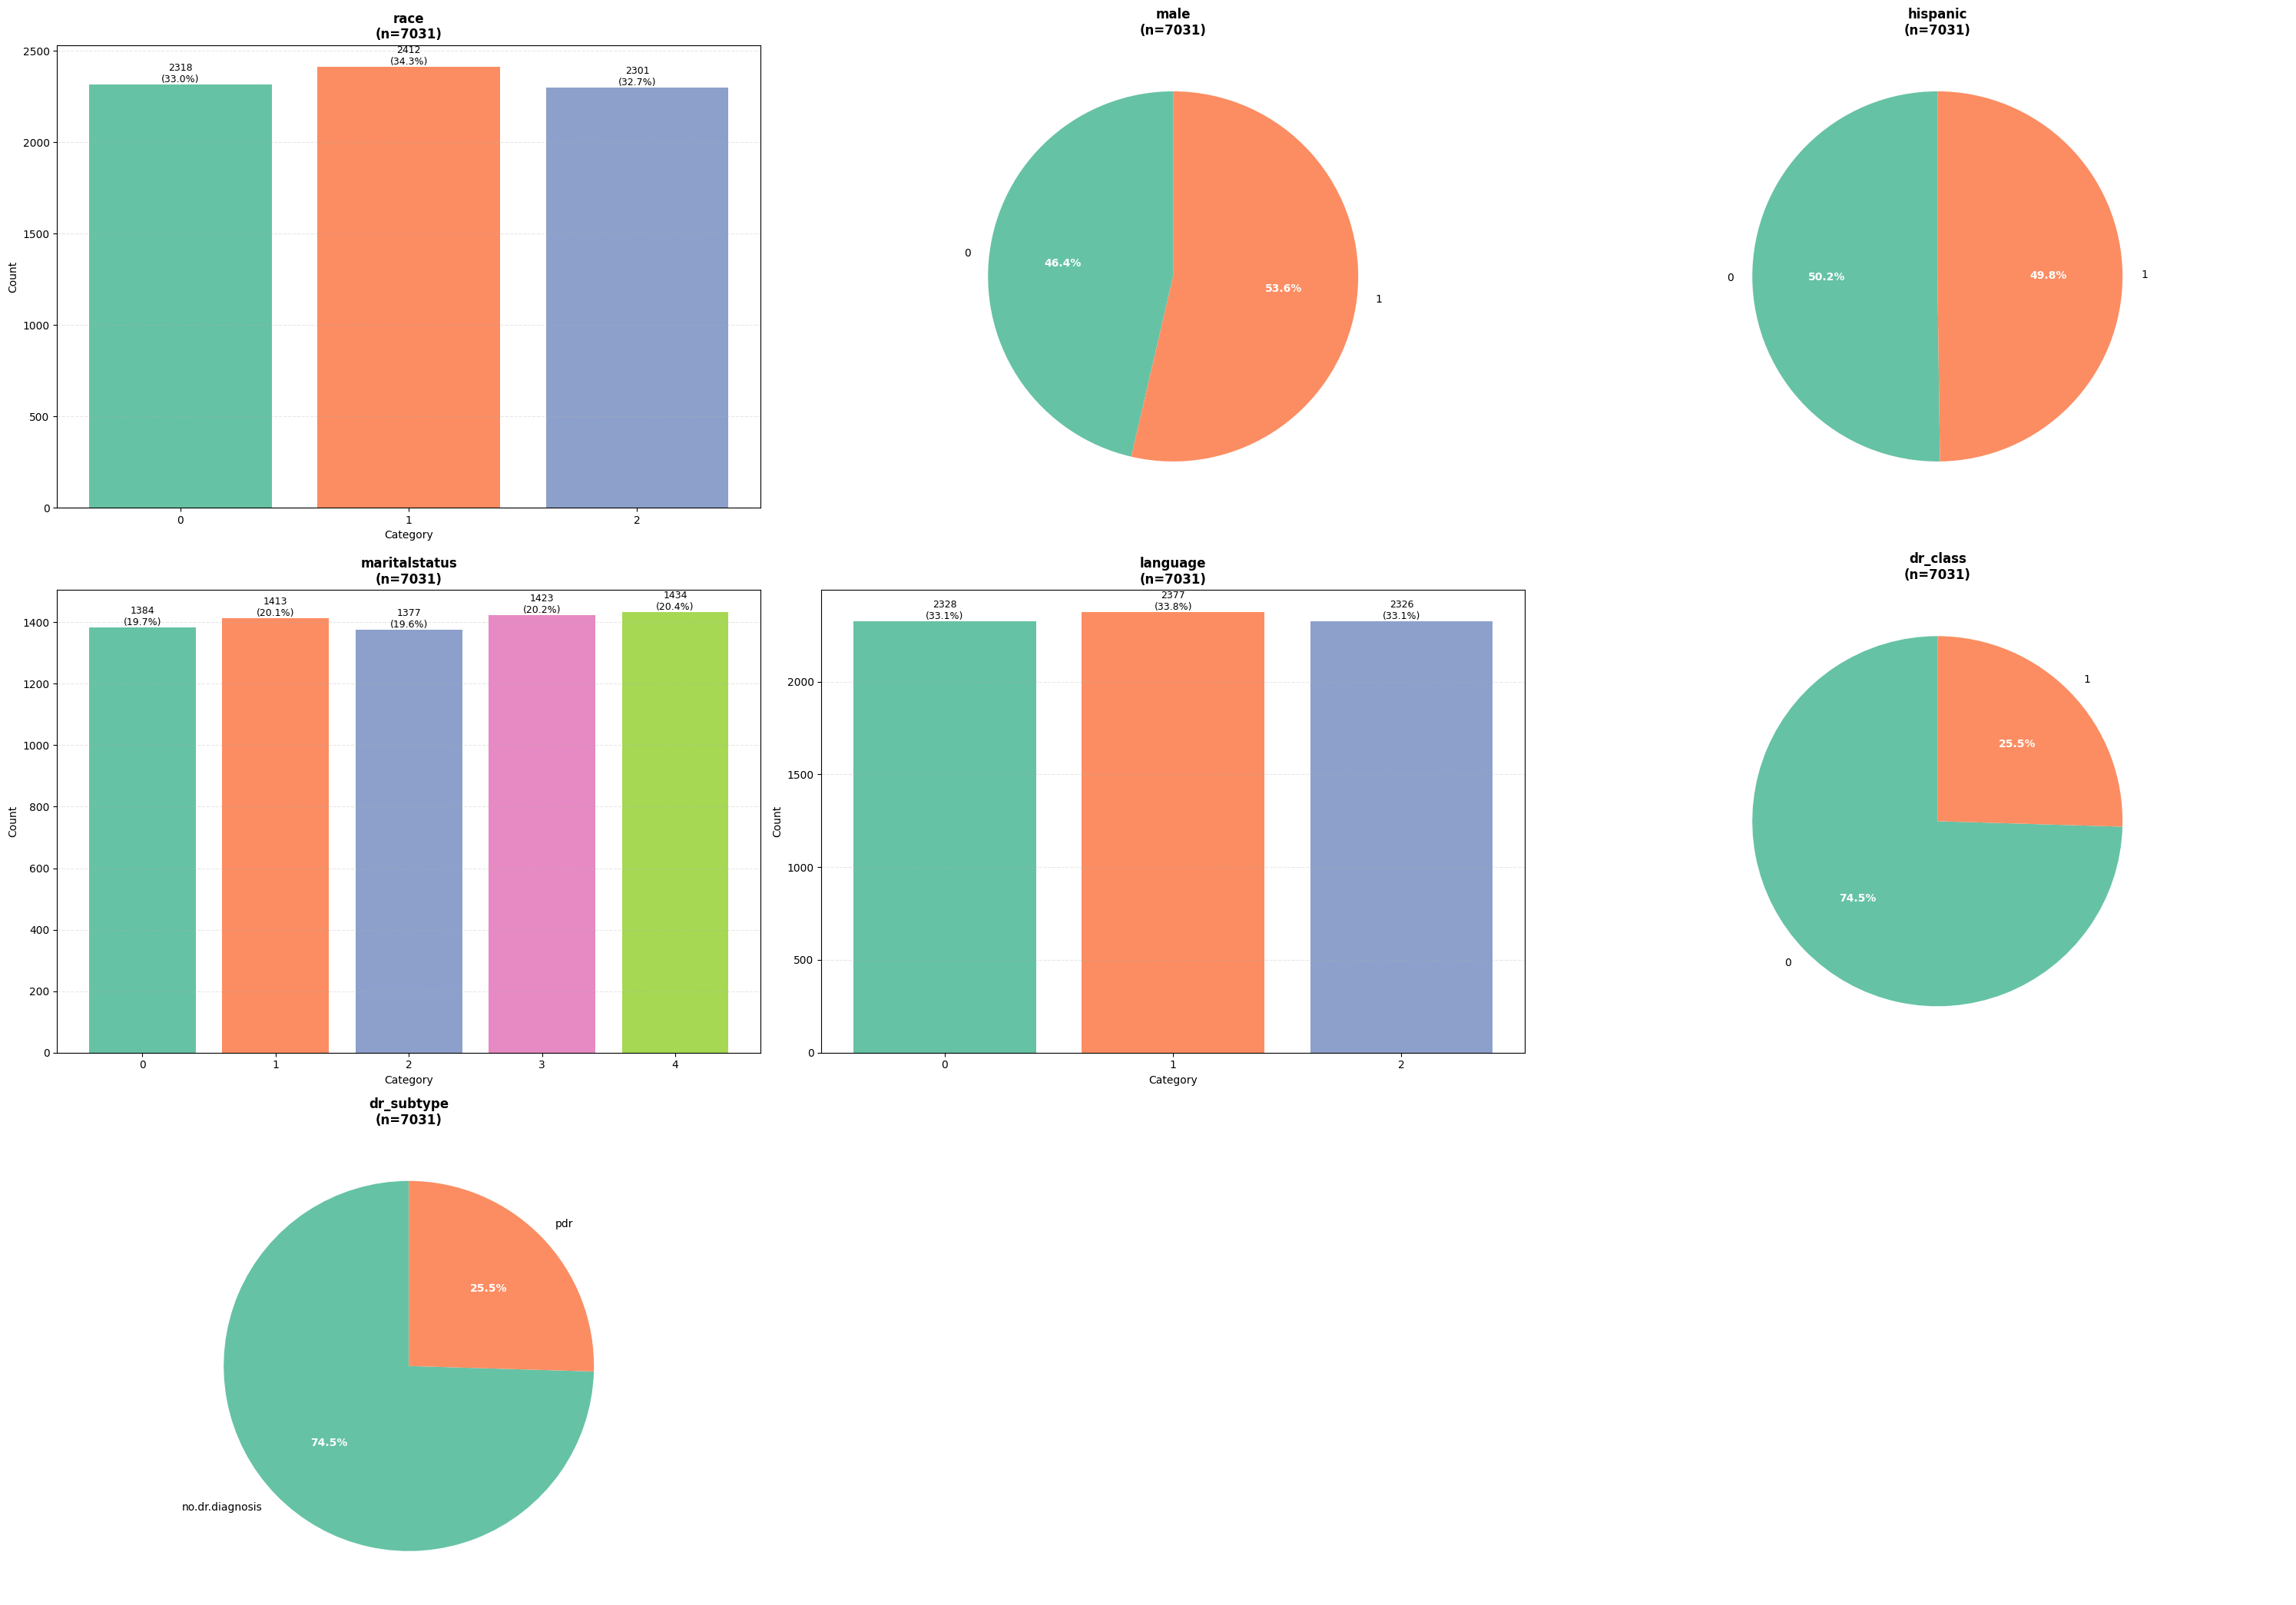


DETAILED STATISTICS

RACE:
--------------------------------------------------
  0:  2318 (32.97%)
  1:  2412 (34.31%)
  2:  2301 (32.73%)

  Split distribution:
    TRAIN: 4476 samples
      0: 1468 (32.8%)
      1: 1545 (34.5%)
      2: 1463 (32.7%)
    VAL: 641 samples
      0: 205 (32.0%)
      1: 218 (34.0%)
      2: 218 (34.0%)
    TEST: 1914 samples
      0: 645 (33.7%)
      1: 649 (33.9%)
      2: 620 (32.4%)

MALE:
--------------------------------------------------
  0:  3260 (46.37%)
  1:  3771 (53.63%)

  Split distribution:
    TRAIN: 4476 samples
      0: 2086 (46.6%)
      1: 2390 (53.4%)
    VAL: 641 samples
      0: 294 (45.9%)
      1: 347 (54.1%)
    TEST: 1914 samples
      0: 880 (46.0%)
      1: 1034 (54.0%)

HISPANIC:
--------------------------------------------------
  0:  3531 (50.22%)
  1:  3500 (49.78%)

  Split distribution:
    TRAIN: 4476 samples
      0: 2247 (50.2%)
      1: 2229 (49.8%)
    VAL: 641 samples
      0: 325 (50.7%)
      1: 316 (49.3%)
    

{'race': {'overall': [2,
   1,
   1,
   0,
   1,
   0,
   2,
   1,
   2,
   2,
   1,
   1,
   0,
   2,
   0,
   0,
   0,
   2,
   1,
   2,
   2,
   0,
   1,
   0,
   2,
   1,
   2,
   2,
   2,
   2,
   2,
   1,
   2,
   0,
   1,
   1,
   0,
   2,
   2,
   2,
   0,
   2,
   0,
   1,
   2,
   0,
   1,
   1,
   2,
   2,
   0,
   0,
   2,
   0,
   1,
   0,
   0,
   0,
   1,
   1,
   2,
   1,
   1,
   1,
   2,
   0,
   1,
   1,
   2,
   0,
   2,
   0,
   2,
   2,
   1,
   0,
   1,
   2,
   2,
   2,
   2,
   0,
   1,
   1,
   1,
   0,
   2,
   2,
   2,
   2,
   2,
   0,
   0,
   1,
   2,
   2,
   2,
   1,
   0,
   0,
   0,
   0,
   2,
   0,
   2,
   2,
   2,
   0,
   2,
   0,
   2,
   1,
   1,
   1,
   1,
   2,
   2,
   1,
   0,
   1,
   1,
   2,
   2,
   2,
   0,
   2,
   0,
   2,
   2,
   0,
   2,
   0,
   1,
   1,
   1,
   2,
   2,
   2,
   0,
   1,
   2,
   1,
   1,
   1,
   2,
   1,
   0,
   1,
   2,
   2,
   1,
   2,
   0,
   0,
   0,
   2,
   1,
   2,
   1,
   1,
   1,
   1,
   2,
   

In [80]:
# Dataset exploration function
def explore_dataset_characteristics(root_dir="./ODIR_Data", 
                                   keys=['race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype'],
                                   use_pie_for_binary=True,
                                   figsize_per_plot=(10, 7),  # Default size: (width, height) per subplot
                                   save_path=None):
    """
    Explore and visualize dataset characteristics.
    
    Args:
        root_dir: Root directory containing train, val, test folders
        keys: List of keys to analyze
        use_pie_for_binary: Use pie chart for binary variables (default: True)
        figsize_per_plot: Figure size for each subplot
        save_path: Optional path to save the figure
    """
    import os
    import glob
    from collections import Counter
    
    # Collect all data
    all_data = {}
    splits = ['train', 'val', 'test']
    total_files = 0
    
    print("Loading dataset...")
    for split in splits:
        split_dir = os.path.join(root_dir, split)
        npz_files = glob.glob(os.path.join(split_dir, "*.npz"))
        total_files += len(npz_files)
        
        for key in keys:
            if key not in all_data:
                all_data[key] = {'overall': [], 'train': [], 'val': [], 'test': []}
            
            for f in npz_files:
                try:
                    data = np.load(f)
                    if key in data:
                        value = data[key].item() if hasattr(data[key], 'item') else data[key]
                        all_data[key]['overall'].append(value)
                        all_data[key][split].append(value)
                except Exception as e:
                    print(f"Error loading {f}: {e}")
    
    print(f"Total files processed: {total_files}")
    print(f"Keys analyzed: {keys}\n")
    
    # Calculate statistics for each key
    num_keys = len(keys)
    cols = 3  # 3 columns for subplots
    rows = (num_keys + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(figsize_per_plot[0] * cols, figsize_per_plot[1] * rows))
    axes = axes.flatten() if num_keys > 1 else [axes]
    
    for idx, key in enumerate(keys):
        ax = axes[idx]
        overall_counts = Counter(all_data[key]['overall'])
        
        # Sort by value for better visualization
        sorted_items = sorted(overall_counts.items())
        categories = [str(k) for k, v in sorted_items]
        counts = [v for k, v in sorted_items]
        total = sum(counts)
        percentages = [c / total * 100 for c in counts]
        
        # Decide chart type
        is_binary = len(categories) == 2
        use_pie = use_pie_for_binary and is_binary
        
        if use_pie:
            # Pie chart for binary data
            colors = plt.cm.Set2(range(len(categories)))
            wedges, texts, autotexts = ax.pie(counts, labels=categories, autopct='%1.1f%%', 
                                             startangle=90, colors=colors, textprops={'fontsize': 10})
            ax.set_title(f'{key}\n(n={total})', fontsize=12, fontweight='bold', pad=10)
            # Make percentage text bold
            for autotext in autotexts:
                autotext.set_color('white')
                autotext.set_fontweight('bold')
        else:
            # Bar chart for multi-category data
            bars = ax.bar(categories, counts, color=plt.cm.Set2(range(len(categories))))
            ax.set_xlabel('Category', fontsize=10)
            ax.set_ylabel('Count', fontsize=10)
            ax.set_title(f'{key}\n(n={total})', fontsize=12, fontweight='bold')
            ax.grid(axis='y', alpha=0.3, linestyle='--')
            
            # Rotate x-axis labels if many categories
            if len(categories) > 5:
                ax.tick_params(axis='x', rotation=45)
            
            # Add count labels on bars
            for bar, count, pct in zip(bars, counts, percentages):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=9)
    
    # Hide unused subplots
    for idx in range(num_keys, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")
    
    plt.show()
    
    # Print detailed statistics
    print("\n" + "="*70)
    print("DETAILED STATISTICS")
    print("="*70)
    
    for key in keys:
        print(f"\n{key.upper()}:")
        print("-" * 50)
        overall_counts = Counter(all_data[key]['overall'])
        total = sum(overall_counts.values())
        
        # Split by train/val/test
        train_counts = Counter(all_data[key]['train'])
        val_counts = Counter(all_data[key]['val'])
        test_counts = Counter(all_data[key]['test'])
        
        # Print overall statistics
        sorted_items = sorted(overall_counts.items())
        for category, count in sorted_items:
            pct = count / total * 100
            print(f"  {category}: {count:5d} ({pct:5.2f}%)")
        
        # Print split statistics
        print(f"\n  Split distribution:")
        for split in splits:
            split_counts = Counter(all_data[key][split])
            split_total = sum(split_counts.values())
            if split_total > 0:
                print(f"    {split.upper()}: {split_total} samples")
                for category, count in sorted(split_counts.items()):
                    pct = count / split_total * 100 if split_total > 0 else 0
                    print(f"      {category}: {count} ({pct:.1f}%)")
    
    return all_data


# Run the exploration
explore_dataset_characteristics(
    root_dir="./ODIR_Data",
    keys=['race', 'male', 'hispanic', 'maritalstatus', 'language', 'dr_class', 'dr_subtype'],
    use_pie_for_binary=True,  # Use pie charts for binary variables
    figsize_per_plot=(10, 7),  # Larger plots: (width, height) for each subplot
    save_path='./dr_notebook_results/dataset_characteristics.png'
)


## Visualization: Compare Backbone Performance

Use the visualization functions to compare performance across different backbones:


Figure saved to: ./dr_notebook_results/backbone_auc_comparison.png


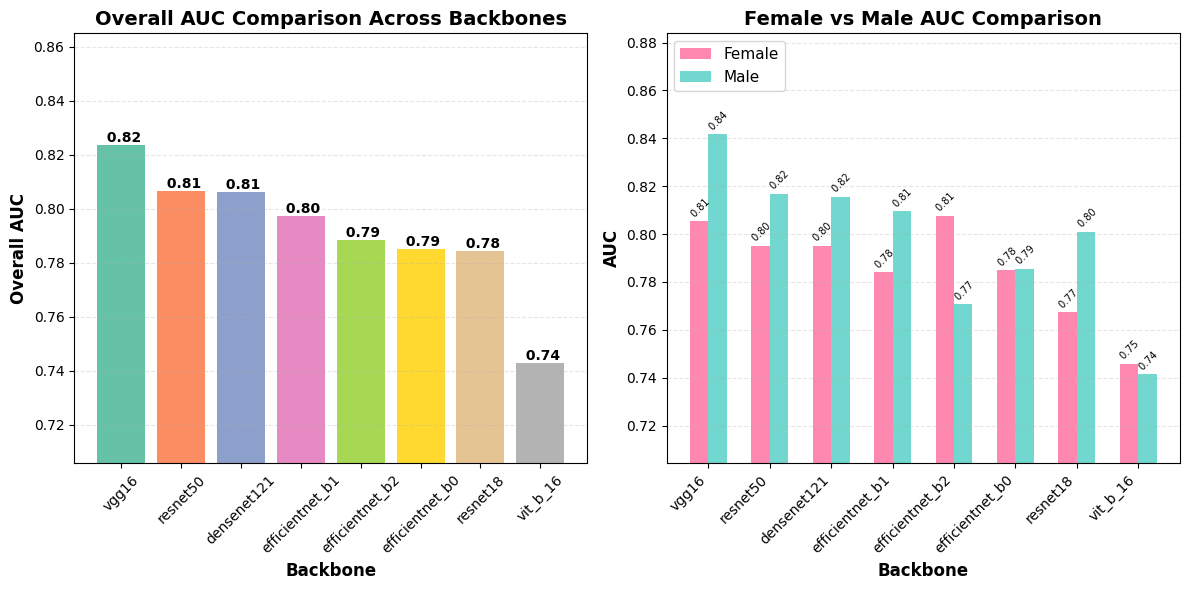

In [69]:
# Horizontal bars (default - bars go left-right)
plot_comparison_from_csv('./dr_results.csv', metric='auc', 
                        save_path='./dr_notebook_results/backbone_auc_comparison.png',
                        orientation='vertical')